# Project 1

Progress update: Still not done, still working. Currently at a convention so I have no had time to make much progress. But I am changing one thing at a time:( .... (today's date: 11/3)

## Documentation of the problem formulation:

For this formulation, I will be considering the initial positions and drag.

Objective function: The objective of this function is to take in consideration the orientation of the rocket and the thrust when landing. In doing so, the objective is to minimize the distance between the rocket and the ground. In other words, minimize the state of the rocket to reach the ground at (0,0).

min ||x||^2


**Variables:**
   
state: x =  [dx, dy, vx, vy, theta ]T
   
action: a = [alpha, delta_theta ]T

**Constraints:**
Dynamics: 

dx(t+1) = dx(t) + vx(t)*delta_t - (1/2)*alpha*(delta_T)^2*alpha*sin(theta)*t

dy(t+1) = dy(t) + vy(t)*delta_t - (1/2)*(delta_T)^2*(alpha*cos(theta)*t - g)

vx(t+1) = vx(t) - delta_t* alpha*sin(theta)*t

vy(t+1) = vy(t) - delta_t* alpha*cos(theta)*t

theta(t+1) = theta(t) + delta_theta


**Assumptions:**
This set up makes the assumption that there is no drag or external factors to take into consideration other than the orientation, accerleration of the rocket, gravity, and position in 2-D. Other, thrust (alpha) is a constant.



## Programming:

In [8]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [9]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81/1000  # gravity constant
BOOST_ACCEL = 14.715/1000  # thrust constant, from class announcement

#L_center_of_gravity = 5 / 1000

# the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [10]:
# System dynamics defined

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):  

        """
        action[0] = thrust controller 
        action[1] = delta theta controller (change in angle)
        state[0] = x
        state[1] = y
        state[2] = x_dot (velocity in the x dir)
        state[3] = y_dot (velocity in the y dir)
        state[4] = theta
        """
        
        # Gravity
        # gravity affects y_dot, so in a 5-by-1 matrix, it affects slot 4
        delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])
        
        # Thrust
        # cos and sin are non linear, used example from slack but changed for my set up below
        state_tensor = t.zeros((5, 2))
        state_tensor[0, 0] = -t.sin(state[4]) 
        state_tensor[2, 0] = -t.sin(state[4]) 
        state_tensor[1, 0] = t.cos(state[4]) 
        state_tensor[3, 0] = t.cos(state[4]) 
        state_tensor[4, 1] = 1
        delta_state = BOOST_ACCEL * FRAME_TIME * t.matmul(state_tensor, action) #redo
        
        # Theta
        # Note: this is not delta_theta but rather the change from time step to time step
        #delta_state_theta = FRAME_TIME * t.matmul(t.tensor([0., 0., 0., 0., 1.]), action[1,0]) #don't know if 1 or -1, redooo

        # Velocity
        state = state + delta_state + delta_state_gravity #+ delta_state_theta
        
        # State (for example, going from step 1 to step 2)
        step_mat = t.tensor([[1., 0., FRAME_TIME, 0., 0.],
                            [0., 1., 0., FRAME_TIME, 0.],
                            [0., 0., 1., 0., 0.],
                            [0., 0., 0., 1., 0.],
                            [0., 0., 0., 0., 1.]])
        state = t.matmul(step_mat, state.T)

        return state

In [11]:
# Deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):    #customize
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here ************************************************************************** edit, don't fully understand this?
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [15]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():   
        state = [5., 5., 1., -2., 0.]  # set the initial states ******************** [x, y, x_dot, y_dot, theta] make sure the orientation and the y-velocity match directions
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2

In [16]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) #set learning rate here *********************************************************

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):       #customize: add graph or line for every state and add labels ******************************************************
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        # labeling data [x, y, x_dot, y_dot, theta]
        x = data[:, 0]
        y = data[:, 1]
        x_dot = data[:, 2]
        y_dot = data[:, 3]
        theta = data[:, 4]
        plt.plot(x, y)
        plt.show()

[1] loss: 448.482


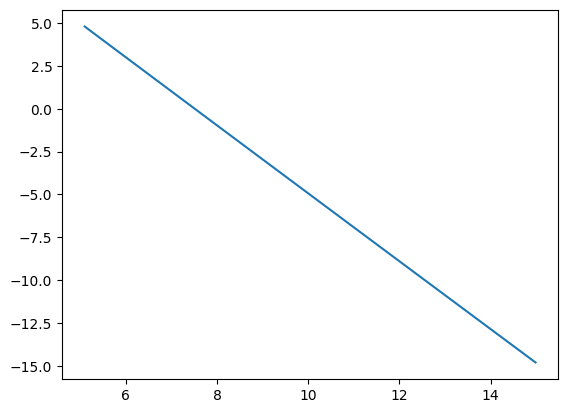

[2] loss: 444.903


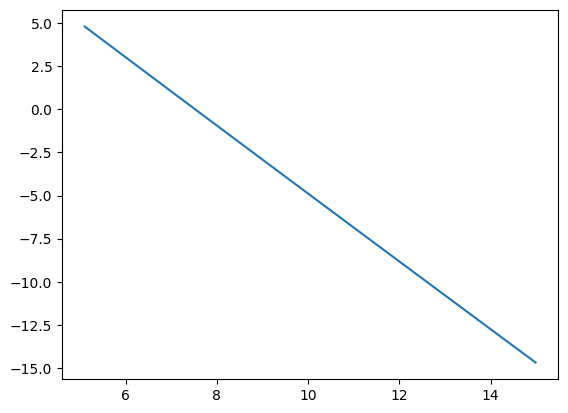

[3] loss: 444.209


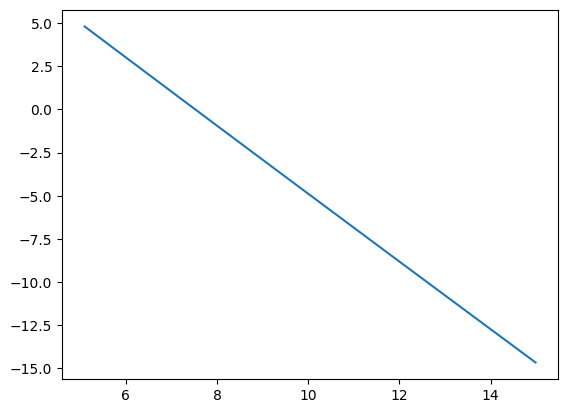

[4] loss: 443.451


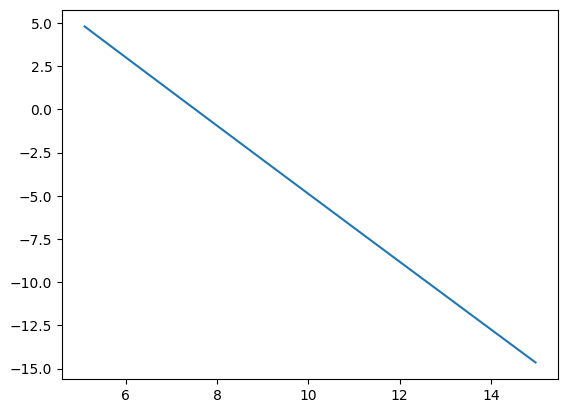

[5] loss: 442.999


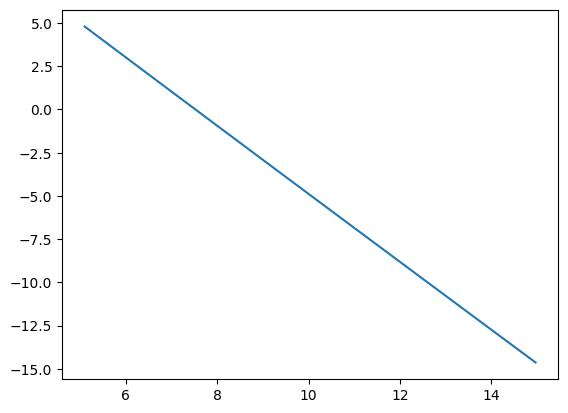

[6] loss: 442.715


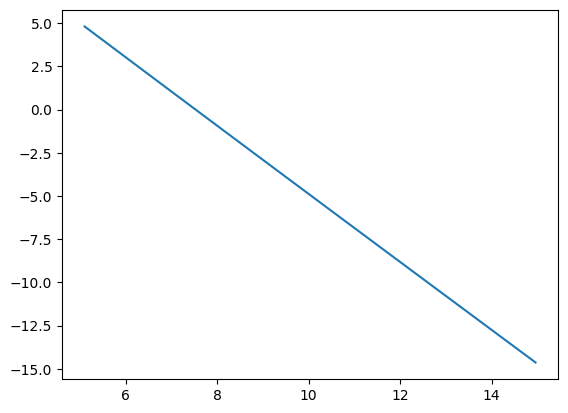

[7] loss: 442.302


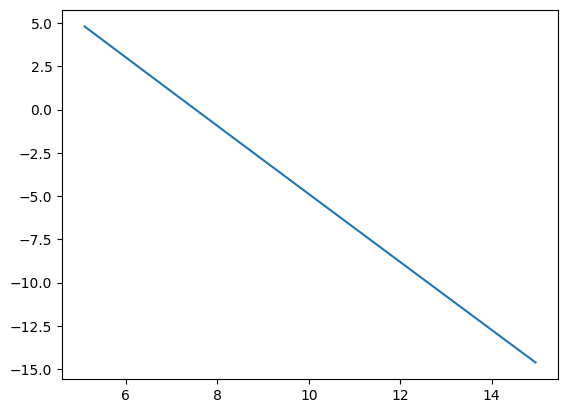

[8] loss: 441.942


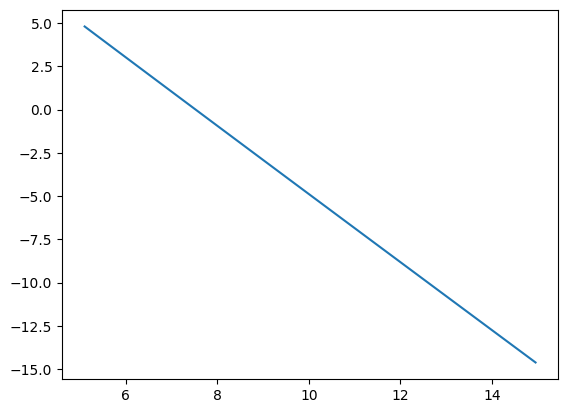

[9] loss: 441.905


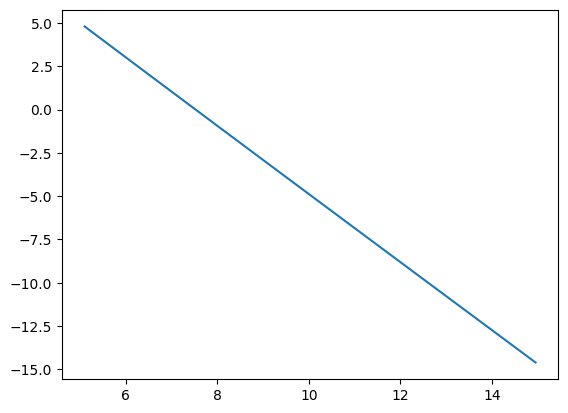

[10] loss: 441.877


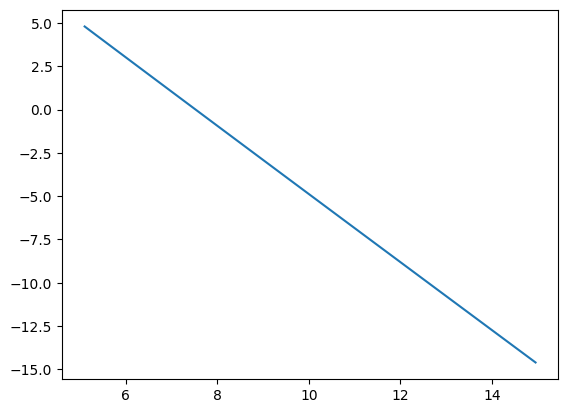

[11] loss: 441.857


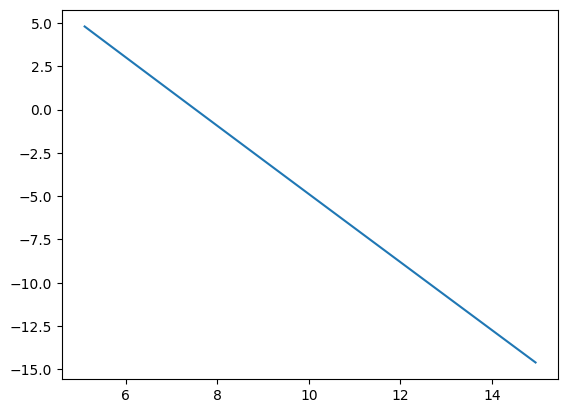

[12] loss: 441.840


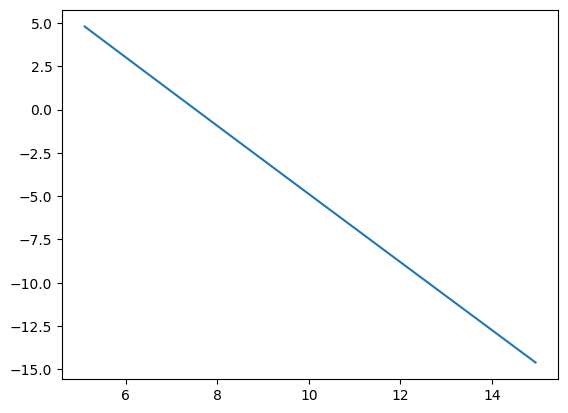

[13] loss: 441.827


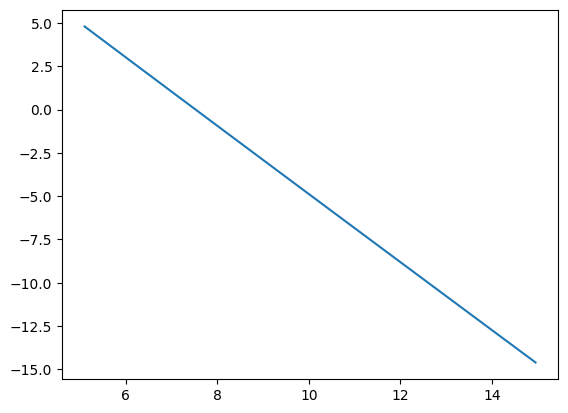

[14] loss: 441.816


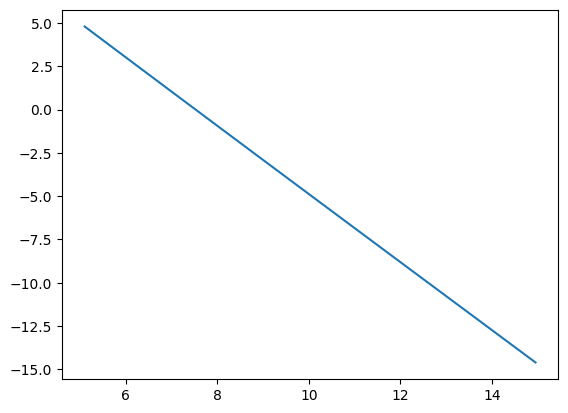

[15] loss: 441.808


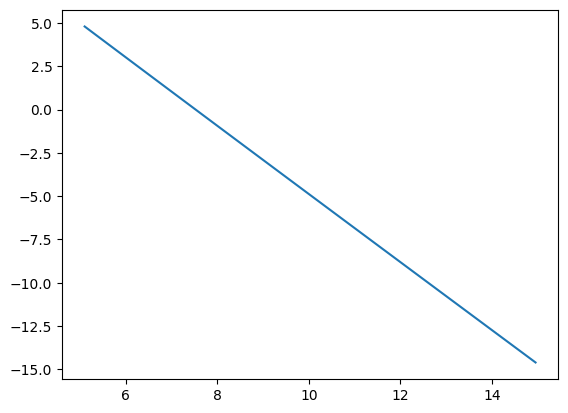

[16] loss: 441.801


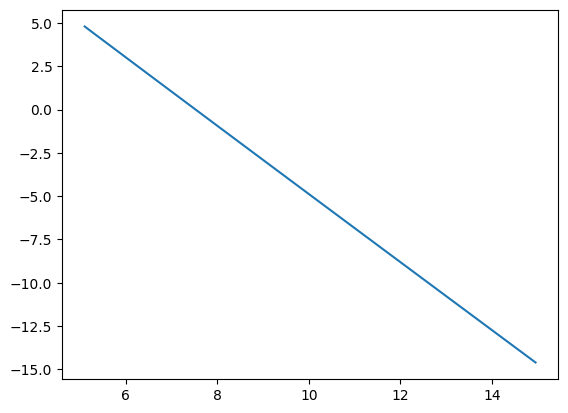

[17] loss: 441.796


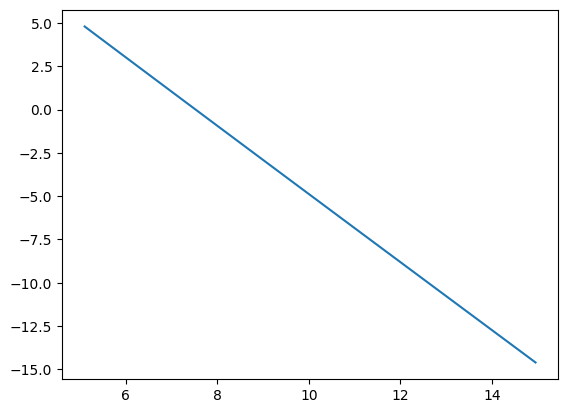

[18] loss: 441.791


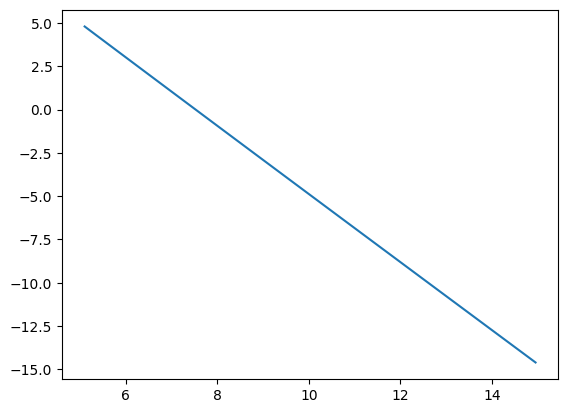

[19] loss: 441.790


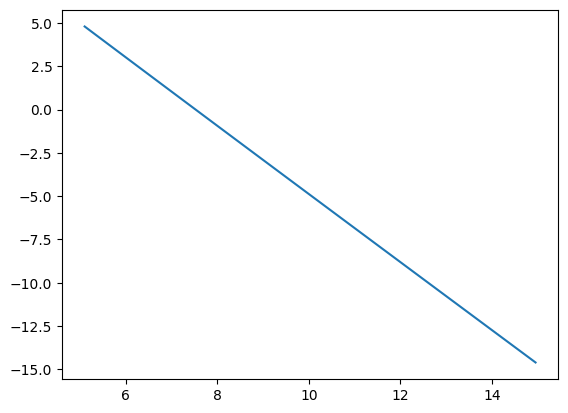

[20] loss: 441.787


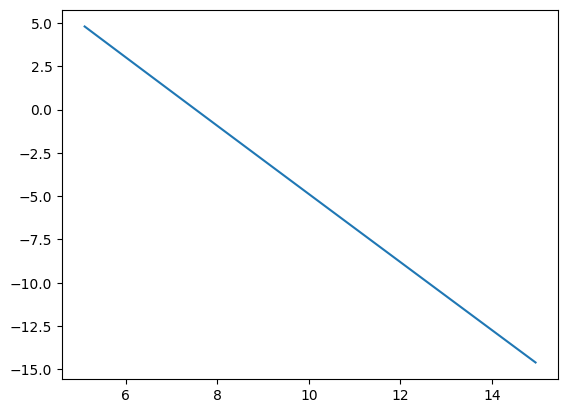

[21] loss: 441.786


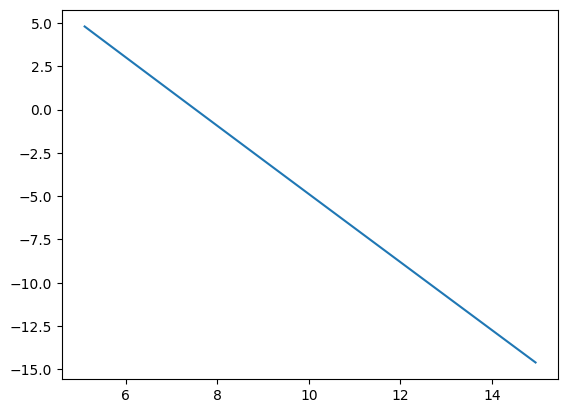

[22] loss: 441.783


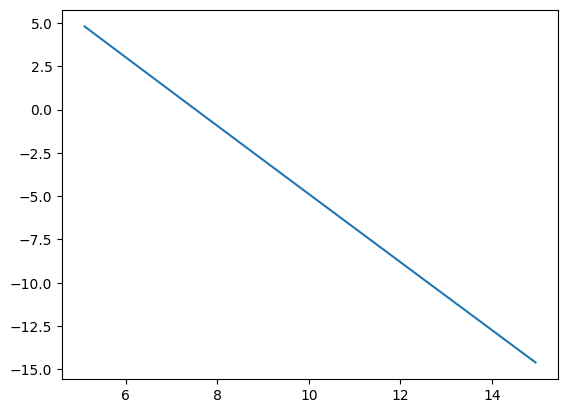

[23] loss: 441.777


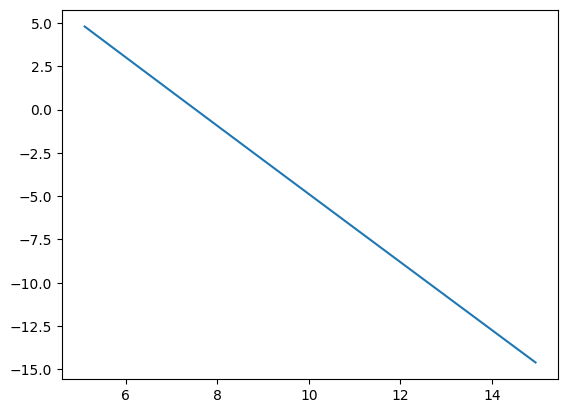

[24] loss: 441.775


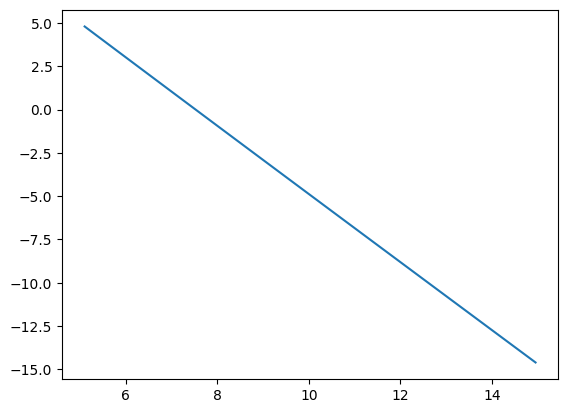

[25] loss: 441.774


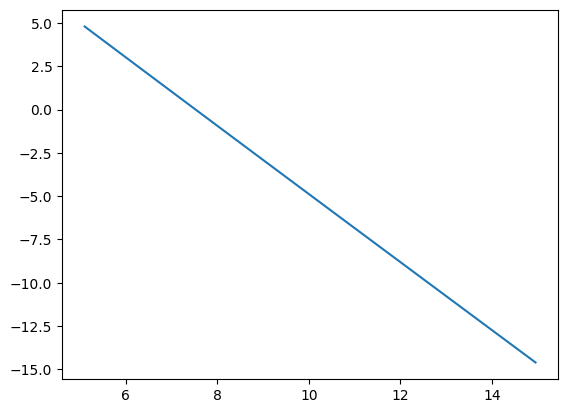

[26] loss: 441.774


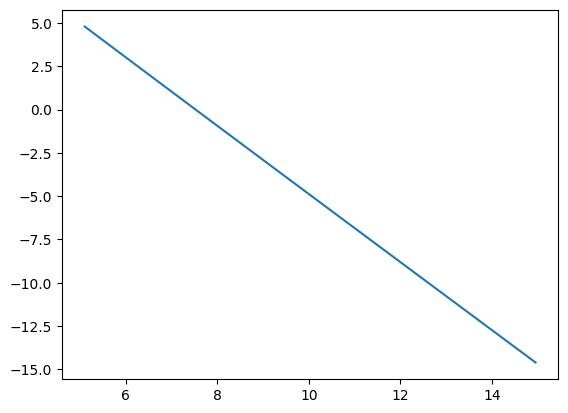

[27] loss: 441.774


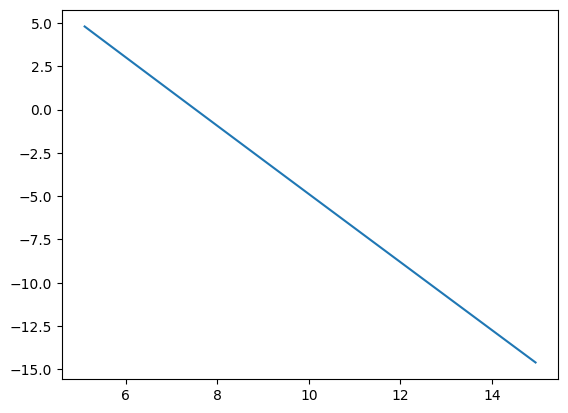

[28] loss: 441.774


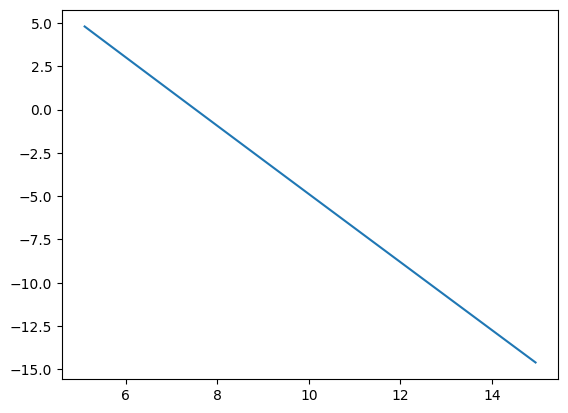

[29] loss: 441.774


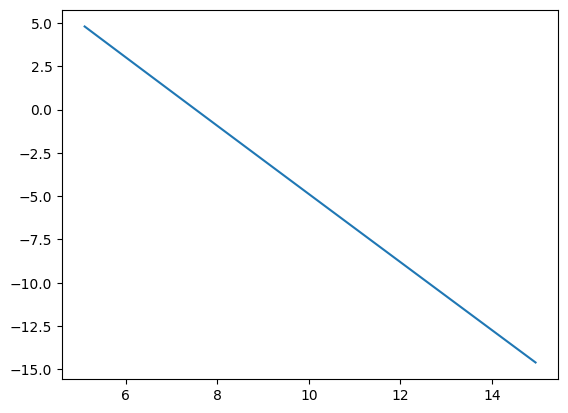

[30] loss: 441.774


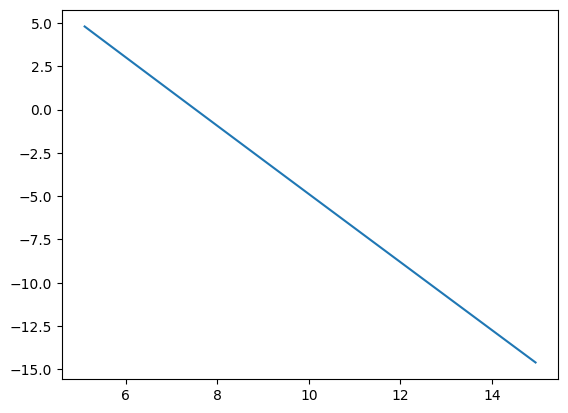

[31] loss: 441.774


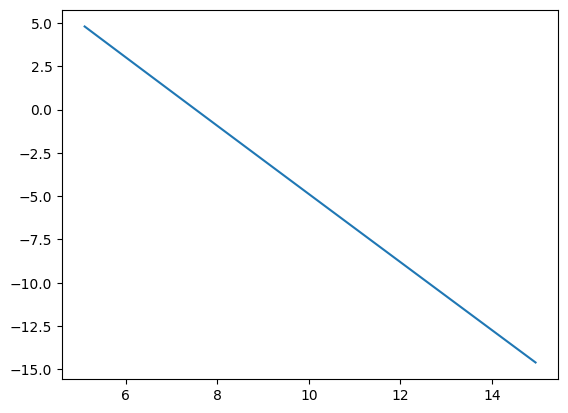

[32] loss: 441.774


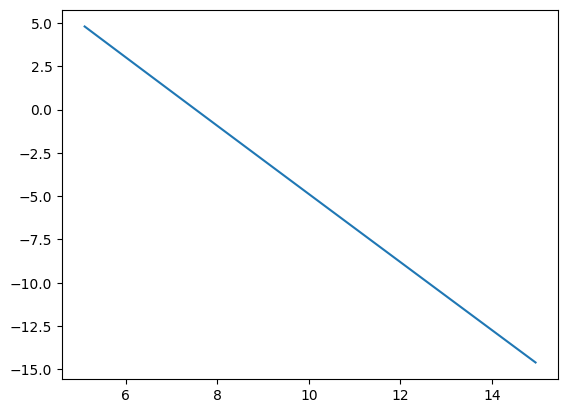

[33] loss: 441.774


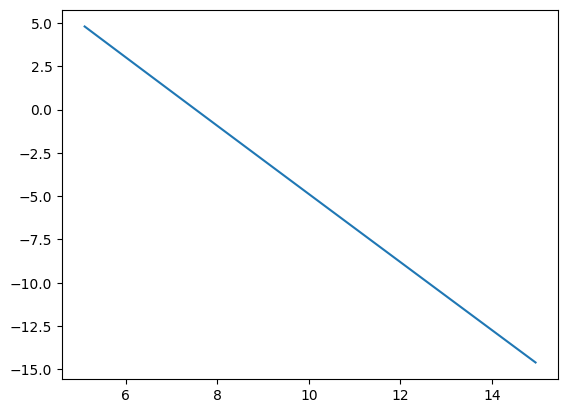

[34] loss: 441.774


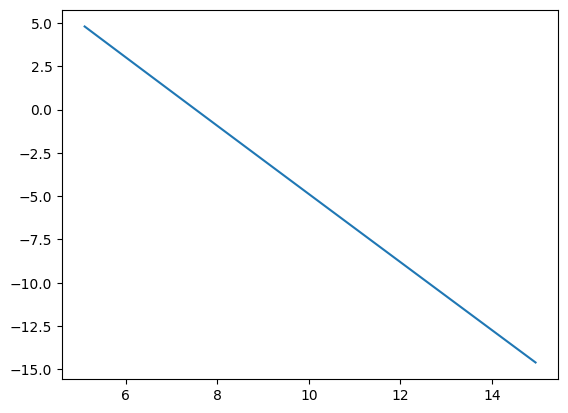

[35] loss: 441.774


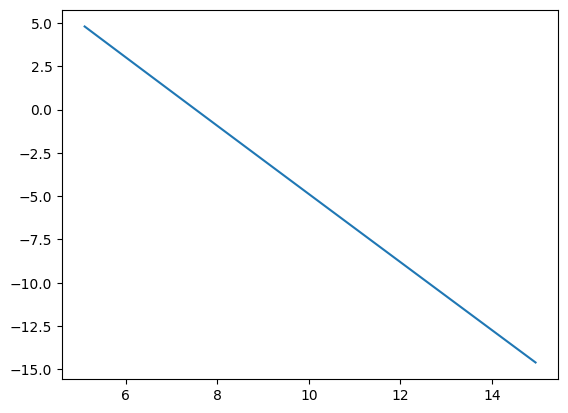

[36] loss: 441.774


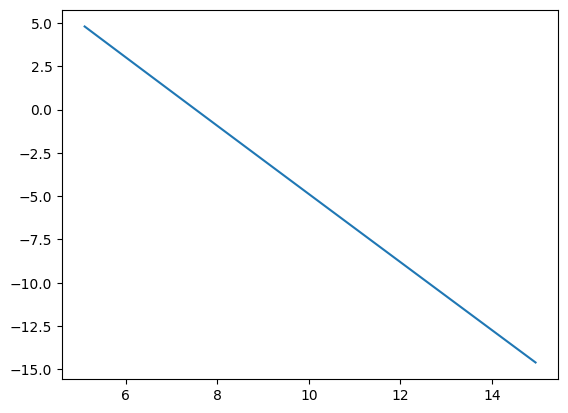

[37] loss: 441.774


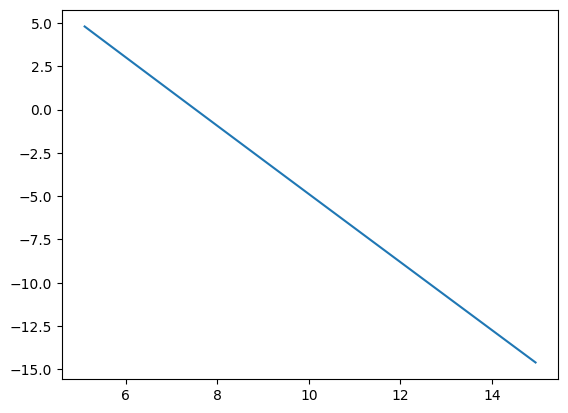

[38] loss: 441.774


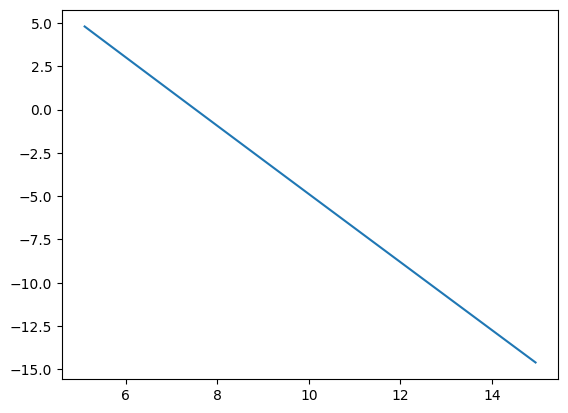

[39] loss: 441.774


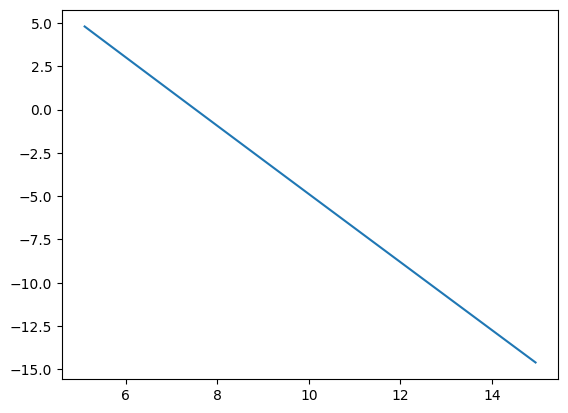

[40] loss: 441.774


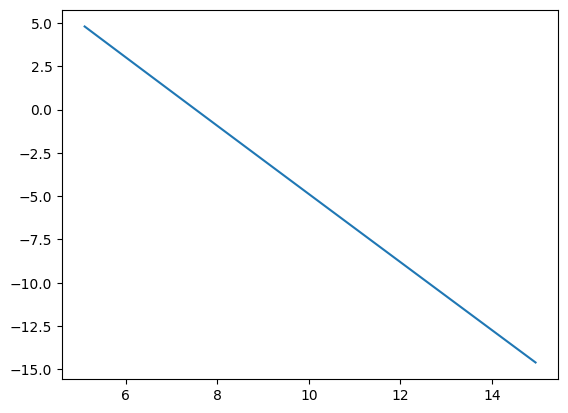

[41] loss: 441.774


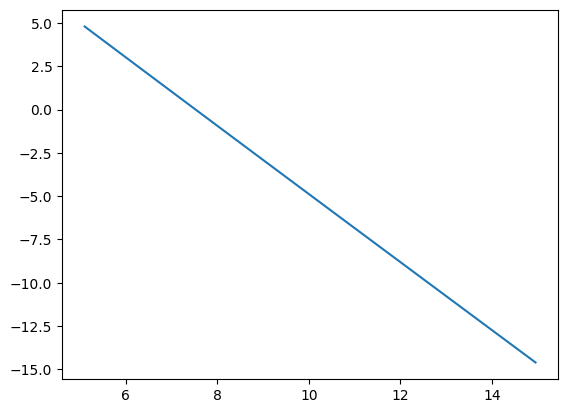

[42] loss: 441.774


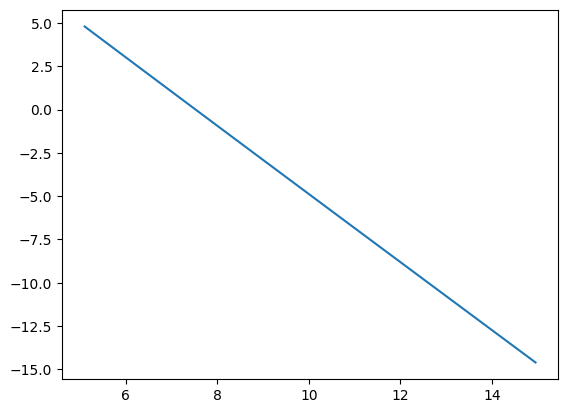

[43] loss: 441.774


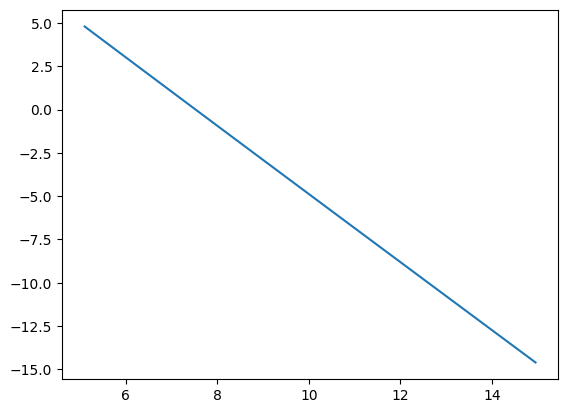

[44] loss: 441.774


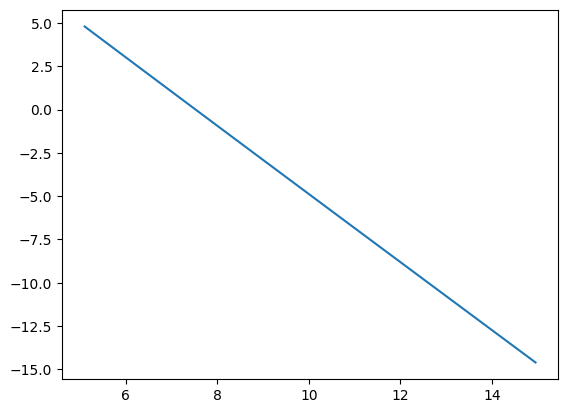

[45] loss: 441.774


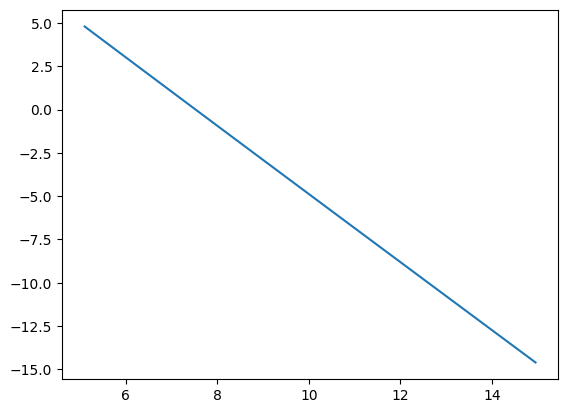

[46] loss: 441.774


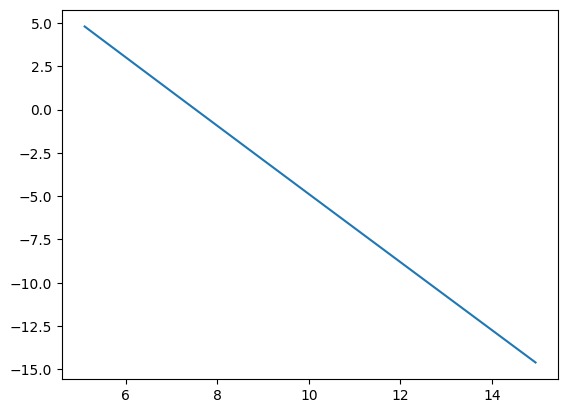

[47] loss: 441.774


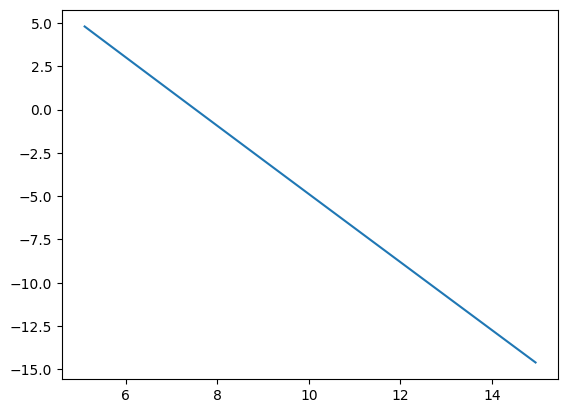

[48] loss: 441.774


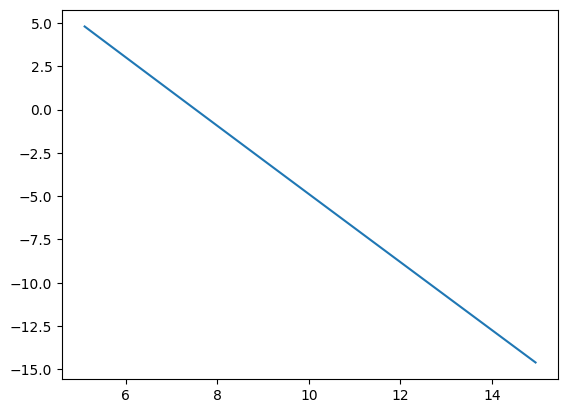

[49] loss: 441.774


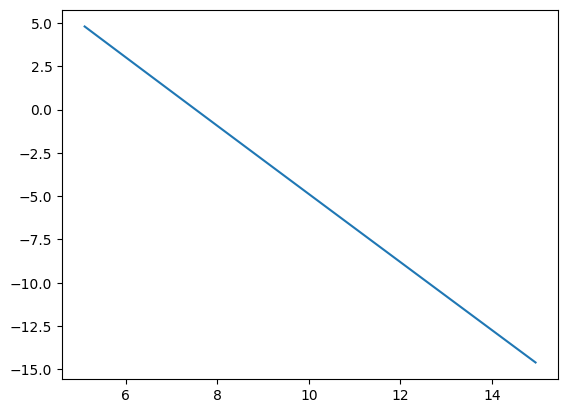

[50] loss: 441.774


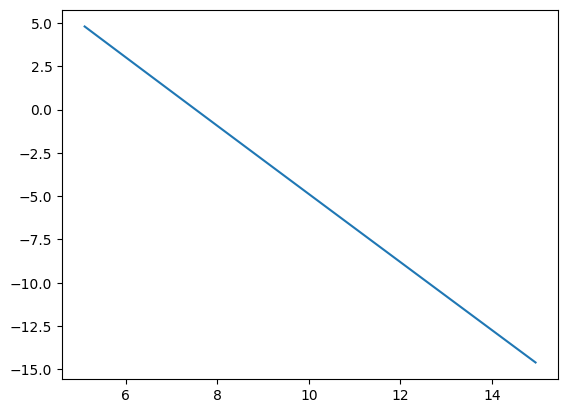

[51] loss: 441.774


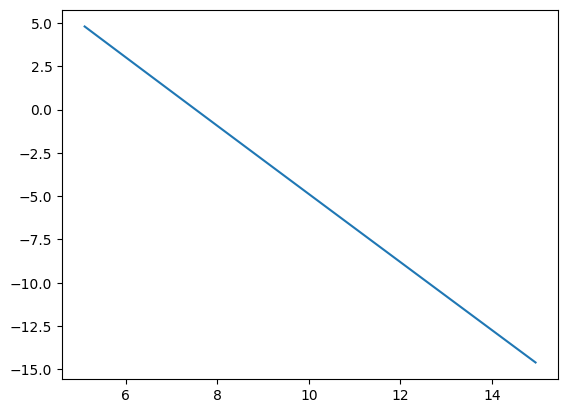

[52] loss: 441.774


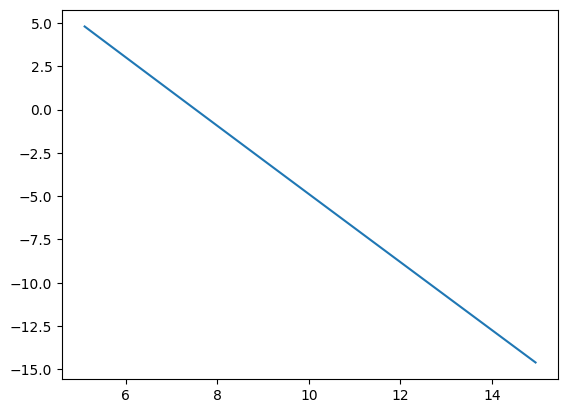

[53] loss: 441.774


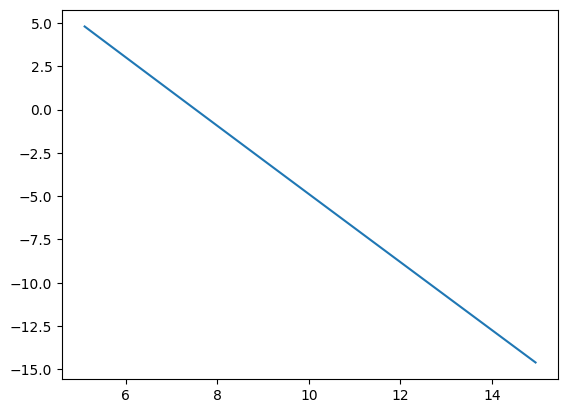

[54] loss: 441.774


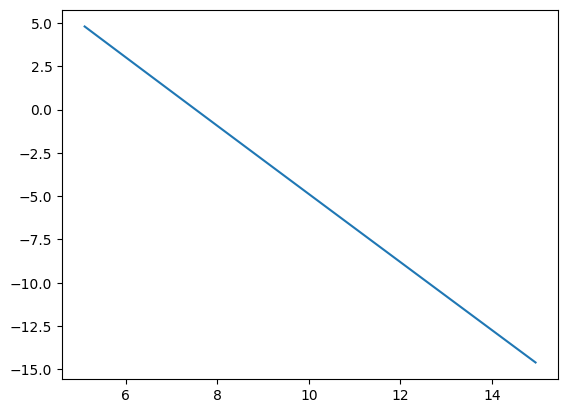

[55] loss: 441.774


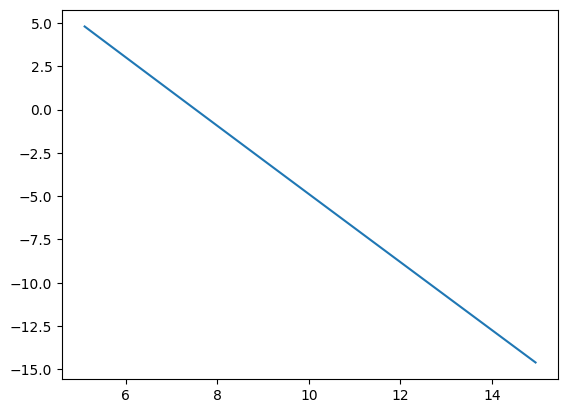

[56] loss: 441.774


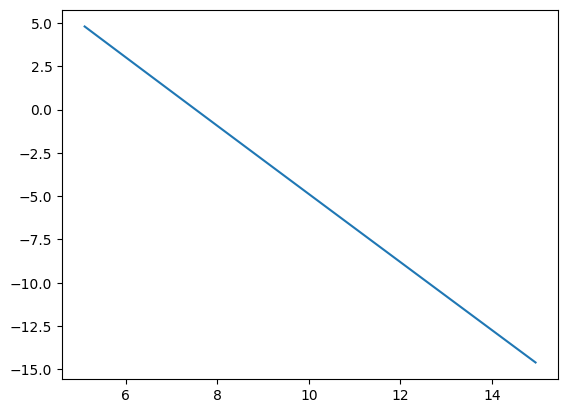

[57] loss: 441.774


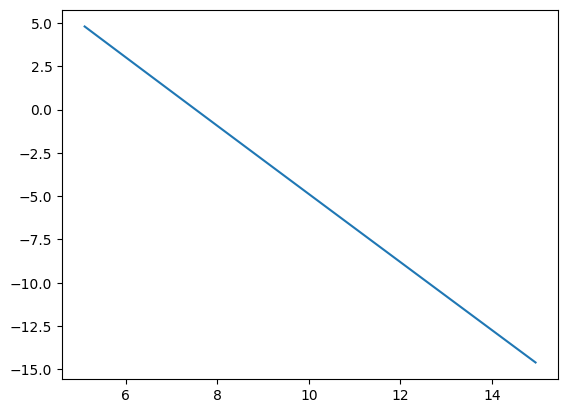

[58] loss: 441.774


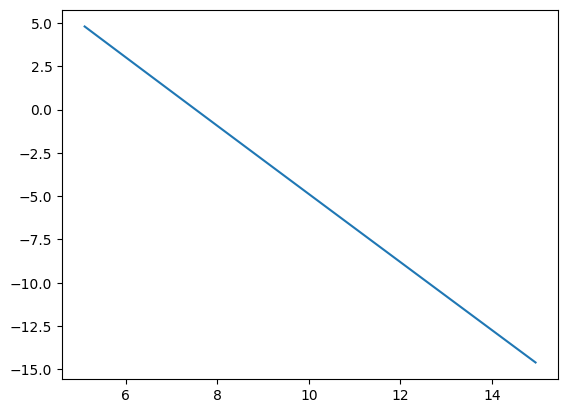

[59] loss: 441.774


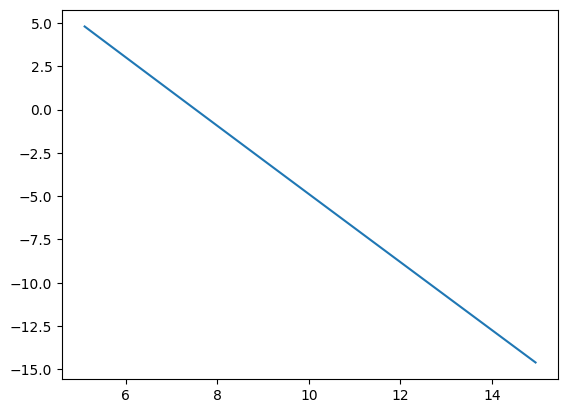

[60] loss: 441.774


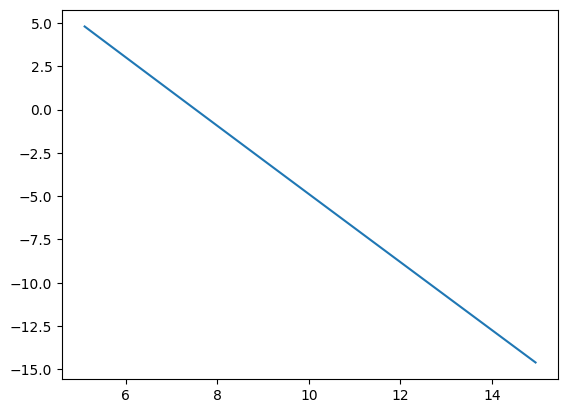

[61] loss: 441.774


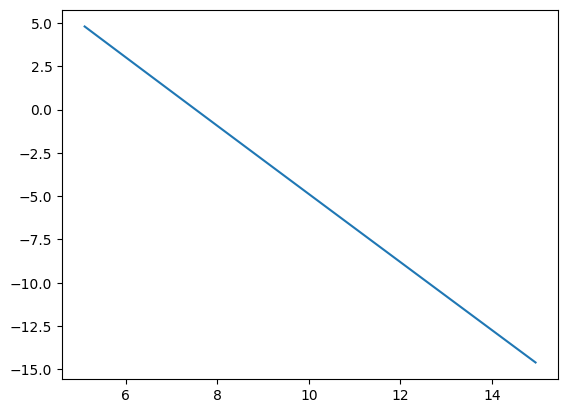

[62] loss: 441.774


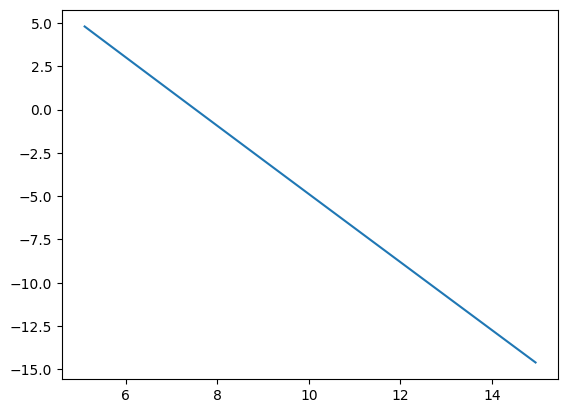

[63] loss: 441.774


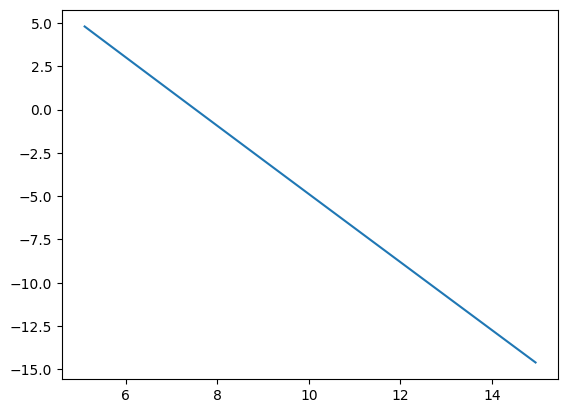

[64] loss: 441.774


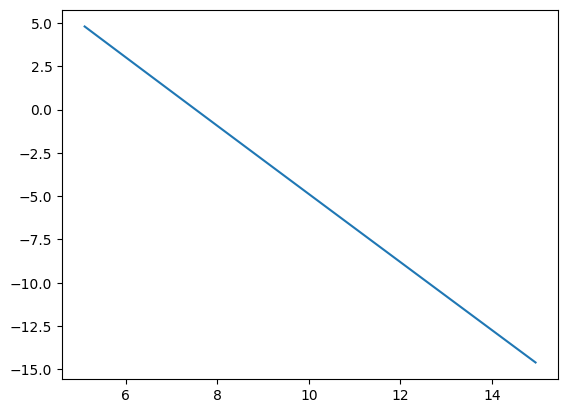

[65] loss: 441.774


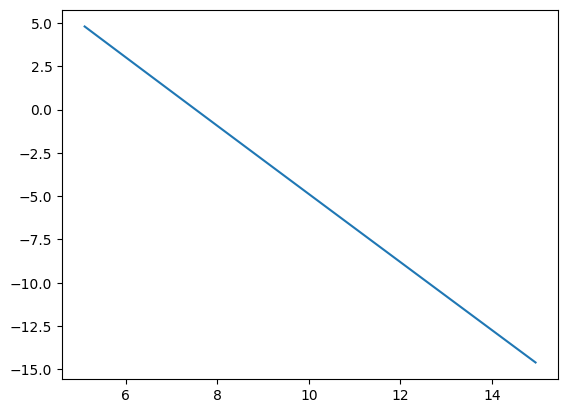

[66] loss: 441.774


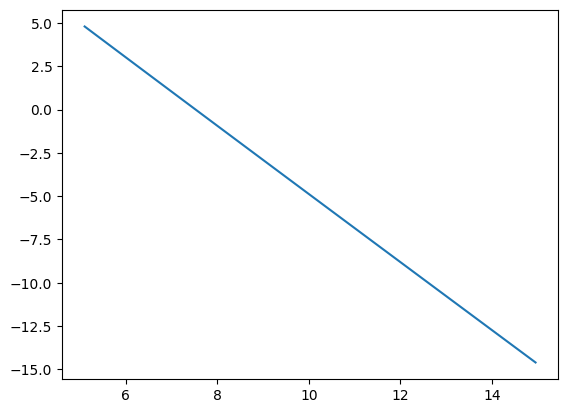

[67] loss: 441.774


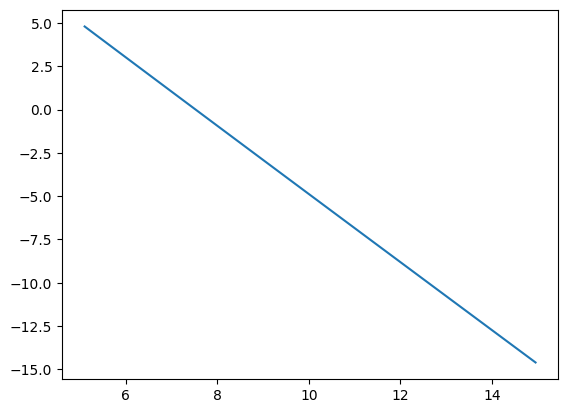

[68] loss: 441.774


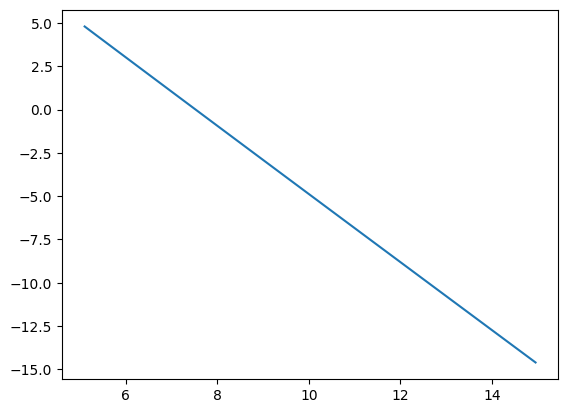

[69] loss: 441.773


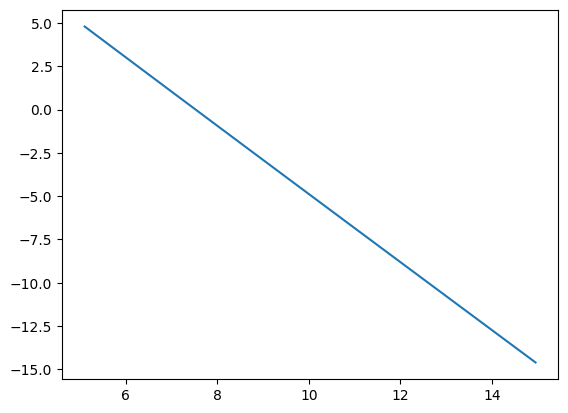

[70] loss: 441.773


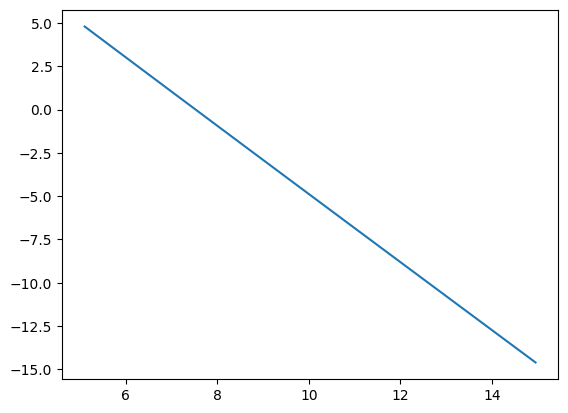

[71] loss: 441.773


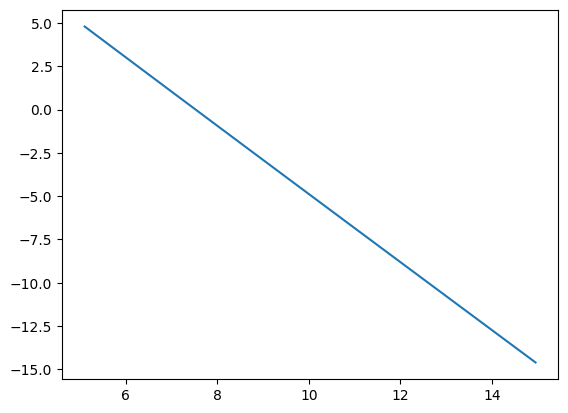

[72] loss: 441.773


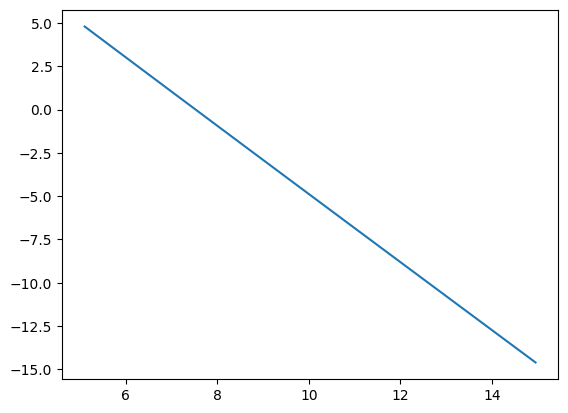

[73] loss: 441.773


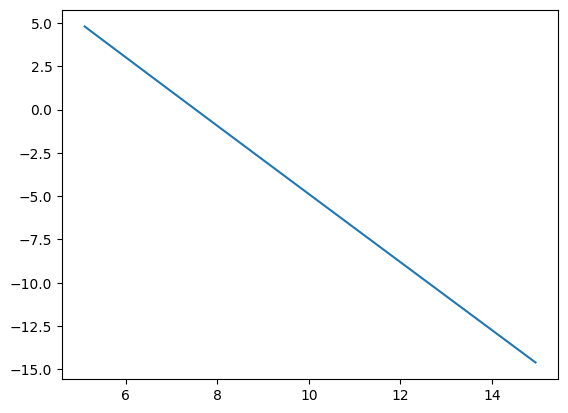

[74] loss: 441.773


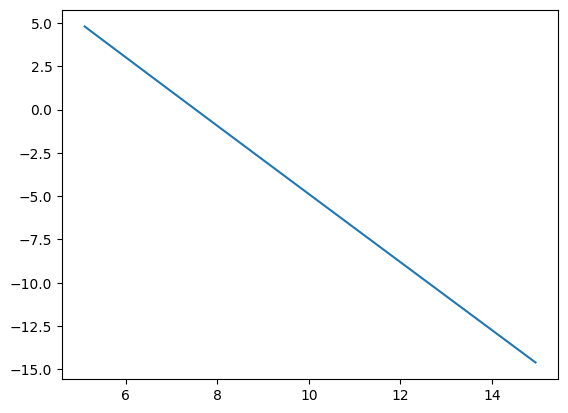

[75] loss: 441.773


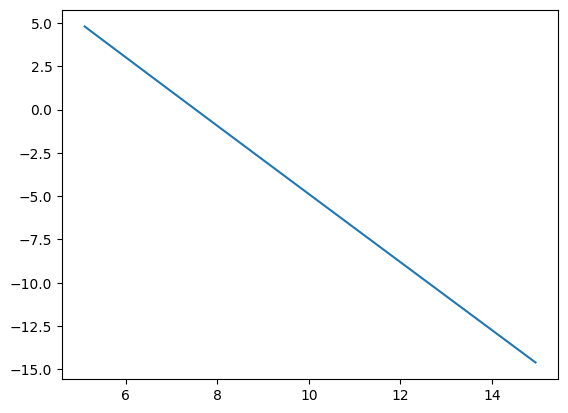

[76] loss: 441.773


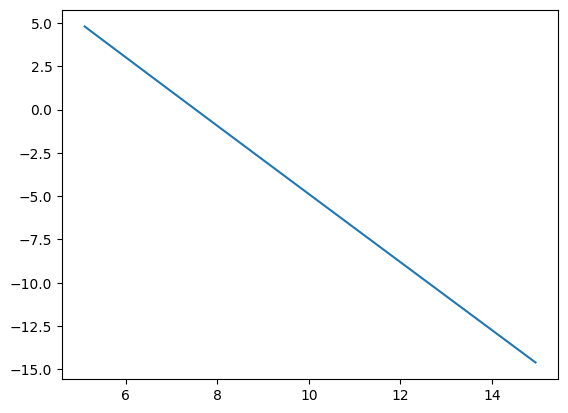

[77] loss: 441.773


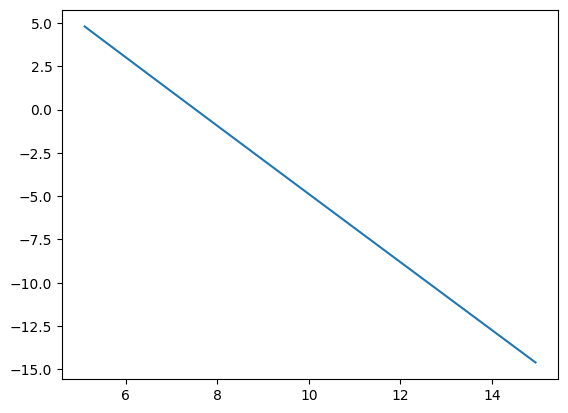

[78] loss: 441.773


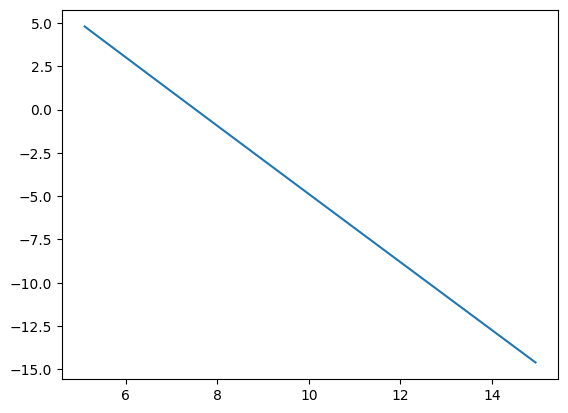

[79] loss: 441.773


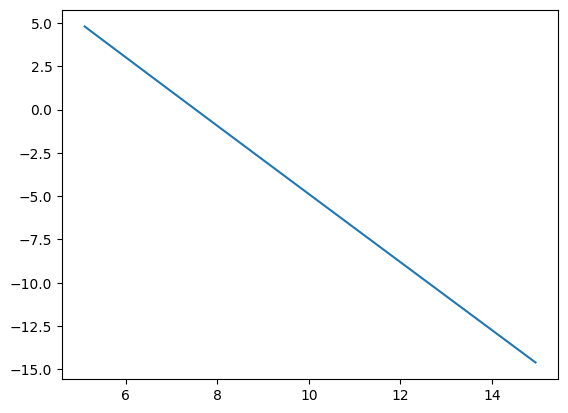

[80] loss: 441.773


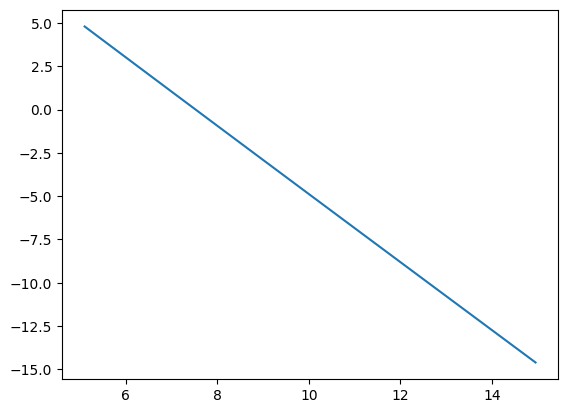

In [17]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(80)  # solve the optimization problem

## Analysis of the results:

## Bonus:

This is not exactly a bonus problem, but I am trying to solve the same rocket problem and take into consideration something other than orientation.

**Documentation:**

This problem takes into consideration drag, or the drag that the wind causes on the rocket. 

Assumption:
The rocket does not rotate, therefore the wind is against the side of the rocket (which is a constant area).

**Code:** 

In [ ]:
# overhead **********************************************************************************************************************************************

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters **********************************************************************************************************************************************

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# system dynamics **********************************************************************************************************************************************

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state
    
# a deterministic controller **********************************************************************************************************************************************

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action
    
# the simulator that rolls out x(1), x(2), ..., x(T) **********************************************************************************************************************************************

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2
    
# set up the optimizer **********************************************************************************************************************************************

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()
        
# Now it's time to run the code! **********************************************************************************************************************************************

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

**Analysis:**